In [135]:
from gensim.models.ldamodel import LdaModel
import gensim
import pandas as pd
import glob
from nltk.corpus import stopwords
import string
from gensim import corpora,models
from gensim.utils import lemmatize # Only keep nums
from gensim.corpora import Dictionary
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
import sys
import numpy as np
import enchant
%config InlineBackend.figure_format = 'retina'

In [2]:
def process_text(content_list):
    """
    stopwords
    
    punctuation
    
    digits
    
    english words
    
    """
    typical_words = ['light','therapy','facial','skin','rt','treatment']
    stoplist = stopwords.words('english') + typical_words 
    
    remove_digits = str.maketrans('', '', string.digits)
    remove_punctuation = str.maketrans('', '', string.punctuation)
    
    dict_english = enchant.Dict("en_US")
    
    lemma = WordNetLemmatizer()
    
    content_cleaned =[i.translate(remove_digits) for i in content_list]
    
    content_cleaned = [i.translate(remove_punctuation) for i in content_cleaned]
    
    content_cleaned = [[lemma.lemmatize(word.lower()) for word in line.split()
                        if (word.lower() not in stoplist) and dict_english.check(word.lower())==True] for line in content_cleaned]

    return content_cleaned

In [4]:
content = pd.read_csv('text.csv',encoding = 'iso-8859-1',header=None)
content.columns = ['content']
content['content']
print(len(content))
content_list = content['content'].values
cleaned_list = process_text(content_list)
print('after process....')
print(len(cleaned_list))

8001
after process....
8001


Reviews with no extracted value

In [42]:
len(list(filter(lambda x:x==[],cleaned_list)))

62

** Build Dict **

In [43]:
dictionary = Dictionary(cleaned_list)
corpus = [dictionary.doc2bow(text) for text in cleaned_list]

** Topic Modeling **

In [44]:
num_topics = 10
lda = LdaModel(corpus, num_topics= num_topics,id2word = dictionary)
lda.show_topics(num_topics,15)

[(0,
  '0.016*"led" + 0.013*"ultrasonic" + 0.012*"home" + 0.011*"galvanic" + 0.009*"plus" + 0.009*"nutrition" + 0.009*"sun" + 0.009*"damage" + 0.008*"million" + 0.008*"affect" + 0.007*"according" + 0.007*"estimated" + 0.007*"disorder" + 0.007*"treatment" + 0.006*"lifting"'),
 (1,
  '0.098*"technology" + 0.098*"energy" + 0.098*"panel" + 0.098*"stop" + 0.098*"brighten" + 0.098*"news" + 0.098*"winter" + 0.098*"environment" + 0.098*"bus" + 0.009*"acne" + 0.006*"blue" + 0.004*"led" + 0.003*"red" + 0.003*"sun" + 0.003*"new"'),
 (2,
  '0.033*"led" + 0.022*"skincare" + 0.019*"min" + 0.017*"acne" + 0.016*"high" + 0.016*"like" + 0.016*"intensity" + 0.016*"ultrasound" + 0.015*"focused" + 0.014*"look" + 0.014*"ultrasonic" + 0.014*"spa" + 0.013*"wrinkle" + 0.013*"stuff" + 0.012*"machine"'),
 (3,
  '0.015*"work" + 0.015*"new" + 0.011*"way" + 0.011*"dermatology" + 0.011*"added" + 0.011*"people" + 0.011*"problem" + 0.011*"many" + 0.010*"even" + 0.009*"aging" + 0.008*"may" + 0.008*"related" + 0.008*"vi

** Save the model **

In [53]:
#import pickle
#with open('lda.pickle', 'wb') as handle:
#    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

** Read the model **

In [ ]:
import pickle
with open('lda.pickle', 'rb') as handle:
    lda = pickle.load(handle)

In [45]:
assign = []
for i in range(len(corpus)):
    assign.append(sorted(lda[corpus[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus)):
    conf_score.append(sorted(lda[corpus[i]],key = lambda x:x[1],reverse = True)[0][1])

In [46]:
df_bow = pd.DataFrame({'original_text':content.content.values,
             'corpus':corpus,
            'assign':assign,
            'conf_score':conf_score,
                      'bow':cleaned_list})

** data is been saved in csv file 'topic assign.csv'**

In [58]:
df_bow.to_csv('topic_assign.csv')

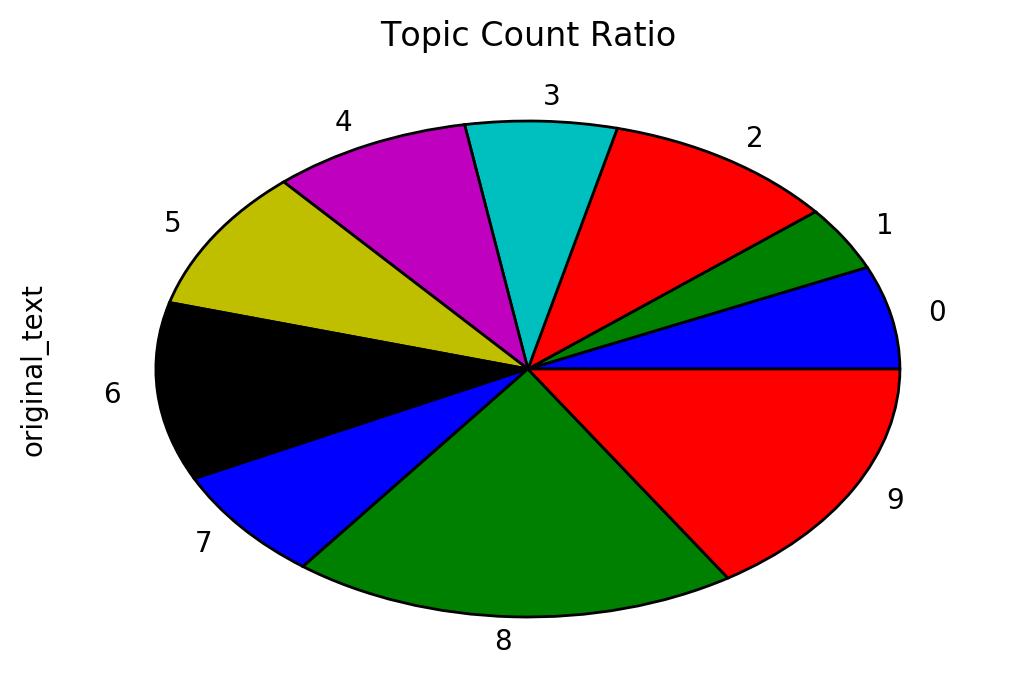

In [136]:
df_bow.groupby('assign').count()['original_text'].plot(kind='pie')
plt.title('Topic Count Ratio')
plt.figure(figsize=(5,5))

check the 8 category

In [54]:
for i in df_bow[df_bow['assign']==8]['original_text'].sample(10):
    print(i+'\n')

RT @DermaSpaDist: How Light Therapy Improves a #Microdermabrasion Treatment dermaspadistributors.com/best-facials-i?  #phototherapy #skincare pic.twitter.com/yb9XyqYJFF

RT @Theralight: Apparently, light therapy can do much more than treat depression!  Take a look at the #skincare possibilities! su.pr/1xpM95

RT @DermaSpaDist: How Light Therapy Improves a #Microdermabrasion Treatment dermaspadistributors.com/best-facials-i?  #phototherapy #skincare pic.twitter.com/yb9XyqYJFF

RT @Theralight: Apparently, light therapy can do much more than treat depression!  Take a look at the #skincare possibilities! su.pr/1xpM95

7 Colors LED Photon Facial Mask Skin Rejuvenation Light Therapy Reduces Wrinkles toys-and-hobbies.info/tysnd/hbbs026/? pic.twitter.com/AsAP9dTzG6

RT @Theralight: Apparently, light therapy can do much more than treat depression!  Take a look at the #skincare possibilities! su.pr/1xpM95

face mask always when watching #realitytv time to re watch the @PumpRules while I @BeautyK

** 9 category is likely to be ads (many general and descriptive words related to promotion, let's see. **

In [48]:
for i in df_bow[df_bow['assign']==9]['original_text'].sample(10):
    print(i+'\n')

reVive Deep-Penetrating Anti-Acne Light Therapy System for $99.99: reVive Deep-Penetrating? goo.gl/fb/yez7zb

RT @skinchats: 10 Tips to Get the Most Out of Light Therapy puls.ly/PFnKig #acne pic.twitter.com/IYfPSaS2f5

Alien looking acne treating light mask from Neutrogena 
#acne #mask #facemask #skincare

light therapy for acne

Video link: https://youtu.be/HeBsRA8_O-w
Acne treatments ? Certain medical procedures may help clear your skin. ... Medical procedures, such as light therapy or chemical peels, may help clear.Lumie Clear is a compact hand-held LED light therapy device clinically proven to treat mild to moderate acne. It combines blue light to attack the bacteria.
Subscribe my channel: https://www.youtube.com/channel/UCCmlDv8vKa4fYqlr-MBD1bQ

Facebook: 
Website: 

light therapy for acne
light therapy for acne at home, light therapy for acne scarring, light therapy for acne rosacea, light therapy for acne during pregnancy, light therapy for acne walmart, light therapy for acne s

** Looks like most of them are actually are ads!!! **

** The model is confident in topic assignment over 80% of the time.**

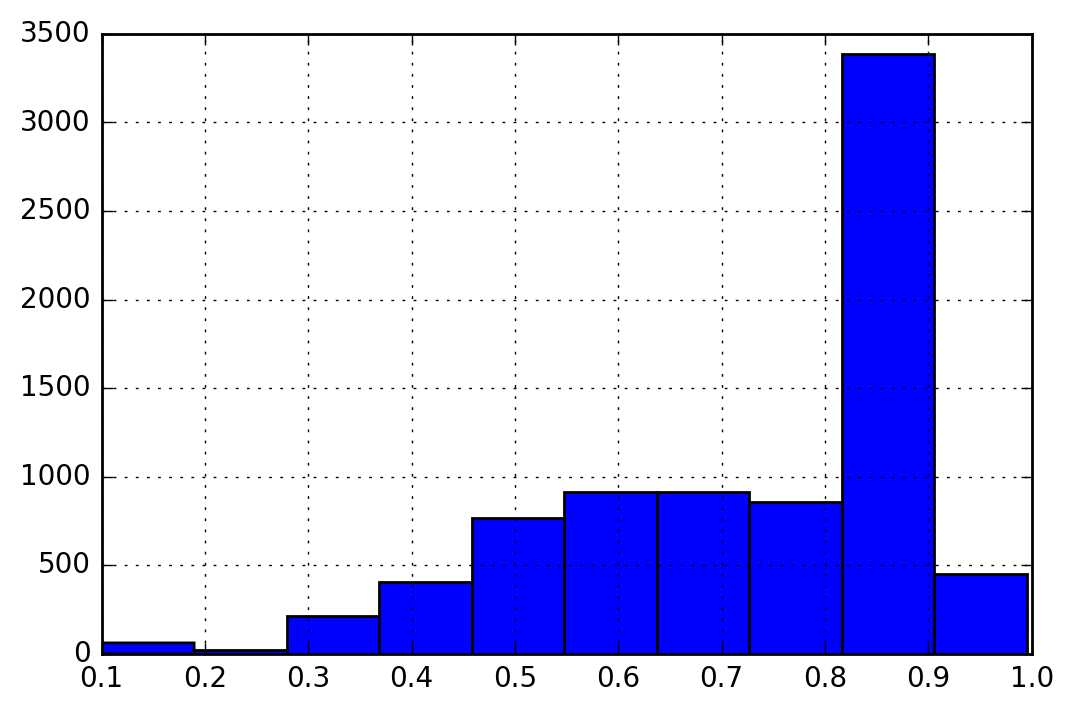

In [137]:
df_bow['conf_score'].hist()

** check records the model not sure of assignment :**

In [41]:
df_bow[df_bow['conf_score']<0.5][['bow','original_text']]

,bow,original_text
3,"[may, face, lotion, lite, review, two, favorit...","Sunday, May 1, 2016\n\nGlyDerm Face Lotion Lit..."
11,"[intranasal, infrared, heal, naturally]",$499 VieLight Intranasal Light Therapy 810 Inf...
31,"[skincare, issue, care]",have any #skincare issues? #olivegold03 and li...
48,"[health, acne, new, blue, color, skincare, acn...",RT @WXU_DEZ_025: #Health #Acne sherif.ws/acne/...
66,"[added, video, hair, mask, acne, lip, smacker]",I added a video to a @YouTube playlist youtu.b...
74,"[talking, away, winter, blue, posted, biologic...",Talking away the winter blues\n\nPosted by Bre...
103,"[attention, new, led, available, come, get, st]",Attention! New LED light therapy now available...
111,"[looking, device, help, shoulder, recover, sur...",While looking for a NIR light therapy device t...
112,"[also, wonder]",Light therapy also does wonders! Led-mask.com
154,"[love, led, face, mask, natural, suit, type, p...",Kourtney Kardashian loves the LED Face Mask.. ...


### Now we try to use TFIDF

In [59]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
num_topics = 10
lda_tfidf = LdaModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
lda.show_topics(num_topics,15)

[(0,
  '0.016*"led" + 0.013*"ultrasonic" + 0.012*"home" + 0.011*"galvanic" + 0.009*"plus" + 0.009*"nutrition" + 0.009*"sun" + 0.009*"damage" + 0.008*"million" + 0.008*"affect" + 0.007*"according" + 0.007*"estimated" + 0.007*"disorder" + 0.007*"treatment" + 0.006*"lifting"'),
 (1,
  '0.098*"technology" + 0.098*"energy" + 0.098*"panel" + 0.098*"stop" + 0.098*"brighten" + 0.098*"news" + 0.098*"winter" + 0.098*"environment" + 0.098*"bus" + 0.009*"acne" + 0.006*"blue" + 0.004*"led" + 0.003*"red" + 0.003*"sun" + 0.003*"new"'),
 (2,
  '0.033*"led" + 0.022*"skincare" + 0.019*"min" + 0.017*"acne" + 0.016*"high" + 0.016*"like" + 0.016*"intensity" + 0.016*"ultrasound" + 0.015*"focused" + 0.014*"look" + 0.014*"ultrasonic" + 0.014*"spa" + 0.013*"wrinkle" + 0.013*"stuff" + 0.012*"machine"'),
 (3,
  '0.015*"work" + 0.015*"new" + 0.011*"way" + 0.011*"dermatology" + 0.011*"added" + 0.011*"people" + 0.011*"problem" + 0.011*"many" + 0.010*"even" + 0.009*"aging" + 0.008*"may" + 0.008*"related" + 0.008*"vi

In [60]:
assign = []
for i in range(len(corpus_tfidf)):
    assign.append(sorted(lda_tfidf[corpus_tfidf[i]],key = lambda x:x[1],reverse = True)[0][0])
conf_score = []
for i in range(len(corpus_tfidf)):
    conf_score.append(sorted(lda[corpus_tfidf[i]],key = lambda x:x[1],reverse = True)[0][1])

In [61]:
df_tfidf = pd.DataFrame({'original_text':content.content.values,
             'corpus':corpus,
            'assign':assign,
            'conf_score':conf_score,
                      'bow':cleaned_list})

** the model is less confident: **

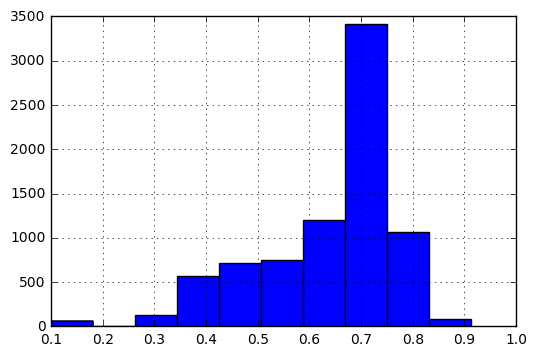

In [62]:
df_tfidf['conf_score'].hist()

** assignment is more evenly distributed: **

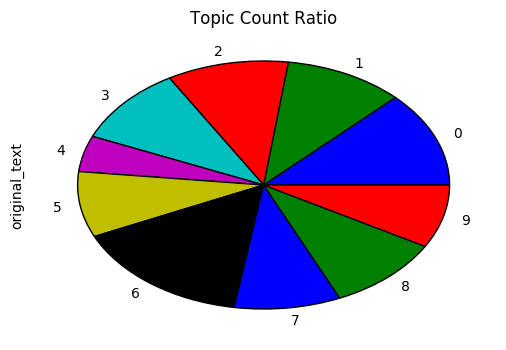

In [63]:
df_tfidf.groupby('assign').count()['original_text'].plot(kind='pie')
plt.title('Topic Count Ratio')
plt.figure(figsize=(5,5))

In [23]:
df_tfidf[df_tfidf['conf_score']<0.5][['bow','original_text']]

,bow,original_text
2,"[spotted, new, favorite, beauty, acne, mask]",@Star_news spotted @Olivia_Holt with her new f...
3,"[may, face, lotion, lite, review, two, favorit...","Sunday, May 1, 2016\n\nGlyDerm Face Lotion Lit..."
25,"[present, doc, peel, wonderful, experience]","#DmvNetworks presents\n\nDC Derm Docs\nBotox, ..."
31,"[skincare, issue, care]",have any #skincare issues? #olivegold03 and li...
48,"[health, acne, new, blue, color, skincare, acn...",RT @WXU_DEZ_025: #Health #Acne sherif.ws/acne/...
49,"[take, control, skincare]",Take control of your #rosacea with an #IPL #Ph...
53,"[color, led, light, photon, rejuvenation, lift...",4 Colors Led Light Therapy Lights Photon Rejuv...
63,"[improves, appearance, application]",RT @Theralight: #Photorejuvenation improves th...
83,"[interested, red, read, skincare]",Interested in having a Red Light Therapy?\nRea...
89,"[opera, led, mask, action, orchid, spa, wellne...",This is the OPERA LED facial mask in action at...


## part of speech 

In [64]:
import nltk
import itertools
from collections import Counter
import operator

In [65]:
corpus_with_pos = list(map(lambda x:nltk.pos_tag(x),cleaned_list))

In [85]:
flattened_cleaned_list = []
for sublist in cleaned_list:
    for val in sublist:
        flattened_cleaned_list.append(val)

In [88]:
flatterned_corpus_with_pos = nltk.pos_tag(flattened_cleaned_list)

** count unique **

In [117]:
deduplicated_df_pos = pd.DataFrame({'word':flattened_cleaned_list,'pos':list(map(lambda x:x[1],flatterned_corpus_with_pos))}).drop_duplicates(subset=['word'])

In [118]:
deduplicated_df_pos.groupby('pos').count().sort(['word'],ascending = False)

C:\Users\mnan\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,word
pos,
NN,3128
JJ,1508
VBG,552
VBD,383
RB,345
VBN,211
VBP,147
NNS,140
VB,120


** count **

In [66]:
sorted(dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[]))))).items(),key=operator.itemgetter(1),reverse = True)

[('NN', 46353),
 ('JJ', 16991),
 ('VBD', 4707),
 ('VBG', 4108),
 ('RB', 3319),
 ('VBN', 2654),
 ('VB', 2081),
 ('VBP', 1519),
 ('NNS', 1293),
 ('IN', 1263),
 ('CD', 533),
 ('VBZ', 470),
 ('JJR', 457),
 ('MD', 420),
 ('JJS', 332),
 ('FW', 175),
 ('RBR', 147),
 ('CC', 139),
 ('PRP', 137),
 ('DT', 99),
 ('NNP', 71),
 ('RBS', 39),
 ('RP', 36),
 ('WP', 33),
 ('WRB', 18),
 ('SYM', 12),
 ('UH', 8),
 ('EX', 6),
 ('WDT', 4),
 ('WP$', 2),
 ('PRP$', 1)]

** check pos interactively **

In [128]:
from ipywidgets import interact
from ipywidgets import Dropdown, FloatSlider
def print_pos(pos):
    
    print(deduplicated_df_pos[deduplicated_df_pos['pos']==pos]['word'])
    
col_list = list(deduplicated_df_pos['pos'].unique())
pos = Dropdown(options=col_list, value=col_list[0], description='Part of Speech')
interact(print_pos, pos=pos)

16         may
127       must
530         ca
2162     could
4119     would
6888     might
63268    shall
Name: word, dtype: object


In [129]:
keep_pos = ['JJ','JJS','JJR','NN','NNP','RB','VB','VBP','VBZ','RBR','VBD','VBN']

In [130]:
list(filter(lambda x: x[0] in keep_pos,dict(Counter(list(map(lambda x: x[1],sum(corpus_with_pos,[]))))).items()))

[('VBZ', 470),
 ('VBN', 2654),
 ('RBR', 147),
 ('VBP', 1519),
 ('JJR', 457),
 ('RB', 3319),
 ('JJ', 16991),
 ('NN', 46353),
 ('NNP', 71),
 ('VB', 2081),
 ('VBD', 4707),
 ('JJS', 332)]

In [131]:
filtered_corpus_with_pos=[]
for i in corpus_with_pos:
    filtered_corpus_with_pos.append(list(filter(lambda x: x[1] in keep_pos,i)))

In [132]:
filtered_corpus_by_pos = []
for i in filtered_corpus_with_pos:
    filtered_corpus_by_pos.append(list(map(lambda x: x[0],i)))

In [133]:
dictionary_pos = Dictionary(filtered_corpus_by_pos)
corpus_pos = [dictionary_pos.doc2bow(text) for text in filtered_corpus_by_pos]

In [134]:
tfidf_by_pos = models.TfidfModel(corpus_pos)
corpus_by_pos_tfidf = tfidf_by_pos[corpus_pos]
num_topics = 10
lda_pos_tfidf = LdaModel(corpus_by_pos_tfidf, id2word=dictionary_pos, num_topics=num_topics)
lda_pos_tfidf.show_topics(num_topics,10)

[(0,
  '0.106*"environment" + 0.105*"bus" + 0.103*"brighten" + 0.100*"stop" + 0.100*"panel" + 0.097*"news" + 0.090*"energy" + 0.087*"technology" + 0.084*"winter" + 0.006*"benefit"'),
 (1,
  '0.017*"remedy" + 0.016*"excellent" + 0.015*"care" + 0.015*"way" + 0.014*"equipment" + 0.014*"salon" + 0.014*"digital" + 0.013*"led" + 0.011*"safest" + 0.011*"consider"'),
 (2,
  '0.042*"violet" + 0.022*"prevent" + 0.020*"acne" + 0.020*"help" + 0.016*"blue" + 0.015*"estimated" + 0.014*"affect" + 0.013*"review" + 0.013*"video" + 0.012*"watch"'),
 (3,
  '0.022*"cause" + 0.021*"think" + 0.013*"skincare" + 0.013*"here" + 0.012*"got" + 0.012*"today" + 0.011*"industry" + 0.011*"hot" + 0.011*"quality" + 0.011*"perhaps"'),
 (4,
  '0.022*"revive" + 0.016*"essential" + 0.016*"complexion" + 0.015*"skincare" + 0.015*"step" + 0.013*"sassy" + 0.013*"winter" + 0.012*"grade" + 0.012*"beautification" + 0.010*"spa"'),
 (5,
  '0.021*"min" + 0.018*"led" + 0.017*"beauty" + 0.016*"matter" + 0.016*"photon" + 0.015*"intens

** try bigram **

In [118]:
bigram = gensim.models.Phrases(cleaned_list,min_count=1, threshold=2)
dictionary_text_list = list(bigram[cleaned_list])
train_text_list = list(bigram[cleaned_list])
dictionary_bigram = Dictionary(dictionary_text_list)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in train_text_list]

C:\Users\mnan\Anaconda3\lib\site-packages\gensim\models\phrases.py:248: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [119]:
num_topics = 10
lda_tfidf = LdaModel(corpus_bigram, id2word=dictionary_bigram, num_topics=num_topics)
lda.show_topics(num_topics,15)

[(0,
  '0.027*"violet" + 0.016*"benefit" + 0.015*"skin" + 0.010*"help" + 0.008*"low" + 0.007*"time" + 0.007*"black" + 0.007*"level" + 0.006*"red" + 0.005*"body" + 0.005*"muscle" + 0.005*"one" + 0.005*"mask" + 0.005*"led" + 0.004*"tone"'),
 (1,
  '0.056*"led" + 0.052*"skin" + 0.030*"wrinkle" + 0.026*"acne" + 0.015*"care" + 0.012*"ultrasound" + 0.012*"ultrasonic" + 0.012*"blue" + 0.011*"high" + 0.011*"red" + 0.010*"intensity" + 0.009*"machine" + 0.009*"focused" + 0.009*"collagen" + 0.008*"rt"'),
 (2,
  '0.019*"day" + 0.017*"new" + 0.017*"mask" + 0.014*"device" + 0.013*"rt" + 0.013*"exciting" + 0.013*"complete" + 0.012*"launching" + 0.011*"added" + 0.007*"medical" + 0.007*"led" + 0.007*"pub" + 0.005*"acne" + 0.005*"patient" + 0.005*"health"'),
 (3,
  '0.099*"led" + 0.061*"mask" + 0.056*"skin" + 0.048*"acne" + 0.042*"beauty" + 0.040*"photon" + 0.040*"rejuvenation" + 0.035*"new" + 0.028*"color" + 0.026*"blue" + 0.025*"red" + 0.018*"care" + 0.016*"sun" + 0.014*"face" + 0.012*"healing"'),
 (4

** Look Bad **

# Conclusion:

#### Bag of Words is the best